## Perform cluster-based correction on somatotopic connectivity scores

In [1]:
%load_ext autoreload
%autoreload 2

from vicsompy.aggregate import Aggregator
from vicsompy.surface import Subsurface
from mne.stats import permutation_cluster_1samp_test
from scipy.stats import t as tdist
from operator import itemgetter as itemgetter
from vicsompy.subject import HcpSubject
from vicsompy.modeling import MssCf
from vicsompy.surface import CiftiHandler
mch=CiftiHandler()
import cortex
import numpy as np
from scipy import stats
from vicsompy.vis import Plot
from vicsompy.utils import load_pkg_yaml, load_plot_pkg_yaml
import os
from scipy.stats import t as tdist
from vicsompy.vis import basic_plot
from mne.stats.cluster_level import _find_clusters, _setup_adjacency

plotviews=load_plot_pkg_yaml()['plotviews']

Load in the rest data.

In [2]:
myagg_rest = Aggregator(expt_id='rs', analysis_name='TEST_REST', agg_name='restagg')  # Create an instance of the Aggregator class for the 'movie' experiment with analysis name 'TEST' and aggregator name 'newagg'
myagg_rest.load_all_sub_frames(myagg_rest.all_subjects)
topsom_rest=np.array([frame['test_scores_somato_score']-frame['null_score_somato'] for frame in myagg_rest.frames])
topsom_rest_c,_=mch.decompose_data(topsom_rest)

Set up the adjacency matrix for cluster-based statistics.

In [3]:
nm=Subsurface('hcp_999999_draw_NH',[np.ones(59292).astype(bool),np.ones(59292).astype(bool)])
nm.get_surfaces()
adjL,adjR=nm.surfaces[0].adj,nm.surfaces[1].adj

In [4]:
critical_t_value=tdist.ppf(1-0.05/2, topsom_rest.shape[0]-1)

Define function for cluster-based t-test.

In [5]:
def cluster_t_test(data,adjL=adjL,adjR=adjR,critical_t_value=critical_t_value,pos=1,n_permutations=2000):
    vertsperhem=int(data.shape[0]/2)
    t_clustL, clusters_L, p_values_L, H0_L = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)
    t_clustR, clusters_R, p_values_R, H0_R = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)

    adjusted_clR_clusters = [c[0] + vertsperhem for c in clusters_R]

    # Combine cluster stats and clusters from both hemispheres
    comb_stats = np.concatenate([p_values_L, p_values_R])   # shape: (n_clusters_L + n_clusters_R,)
    comb_clusters = [c[0] for c in clusters_L]+ adjusted_clR_clusters  # a concatenation of two lists of arrays

    # Sort clusters by their corresponding stats in descending order
    # zip them, sort by stats, then unzip
    sorted_pairs = sorted(zip(comb_stats, comb_clusters), key=itemgetter(0), reverse=False)
    try:
        sorted_stats, sorted_clusters = map(list, zip(*sorted_pairs))
    except ValueError: 
        sorted_stats, sorted_clusters = [0], [0]

    tclust_combined = np.concatenate([t_clustL, t_clustR])
    pos_clust = []
    neg_clust = []
    pos_stats = []
    neg_stats = []

    for clust, stat in zip(sorted_clusters, sorted_stats):
        clust_sum = tclust_combined[clust].sum()
        if clust_sum > 0:
            pos_clust.append(clust)
            pos_stats.append(stat)
        elif clust_sum < 0:
            neg_clust.append(clust)
            neg_stats.append(stat)

    if pos:
        sorted_clusters = pos_clust
        sorted_stats = pos_stats
    clust_masks=[]
    for clust in sorted_clusters:
        empt=np.zeros(int(data.shape[0]))
        empt[clust]=1
        clust_masks.append(empt)

    return sorted_clusters, sorted_stats,clust_masks


In [9]:
cluster_result_rest=cluster_t_test(topsom_rest_c)

stat_fun(H1): min=nan max=nan
Running initial clustering …


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tmp/ipykernel_3938869/588389024.py:3: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustL, clusters_L, p_values_L, H0_L = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 336 clusters


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | Permuting : 0/1999 [00:00<?,       ?it/s]/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/

stat_fun(H1): min=nan max=nan
Running initial clustering …



/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tmp/ipykernel_3938869/588389024.py:4: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustR, clusters_R, p_values_R, H0_R = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 318 clusters


100%|██████████| Permuting : 1999/1999 [00:45<00:00,   44.06it/s]


Get detected clusters for the rest condition.

In [10]:
detected_clusters=np.array(cluster_result_rest[-1])[np.array(cluster_result_rest[1])<.05,:]
detected_clusters*= np.arange(1, detected_clusters.shape[0]+1)[:, None]
flat_clusters=np.max(detected_clusters,axis=0)

In [6]:
uncorrected_t,p=stats.ttest_1samp(topsom_rest_c.T,0,axis=0)

In [ ]:
bin_clust_rest=flat_clusters>0
bin_unc=(uncorrected_t>critical_t_value).astype(int)
rest_diff=(uncorrected_t>critical_t_value).astype(int)-bin_clust_rest

Plot cluster thresholded stats

<Figure size 1800x900 with 0 Axes>

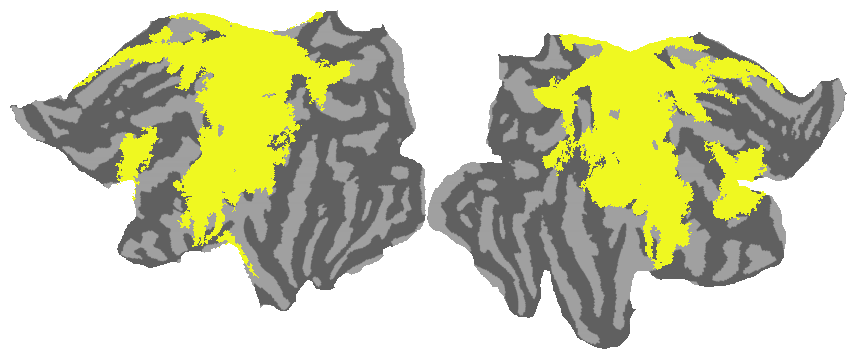

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F1=mp.uber_plot(dat=bin_clust_rest,dat2=bin_clust_rest)

Plot the uncorrected stats.

<Figure size 1800x900 with 0 Axes>

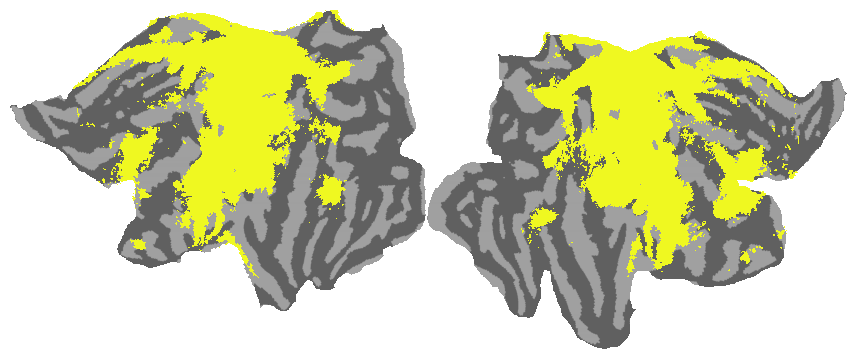

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F1_e=mp.uber_plot(dat=bin_unc,dat2=bin_unc)

Plot the difference between the cluster thresholded stats and the uncorrected stats.

<Figure size 1800x900 with 0 Axes>

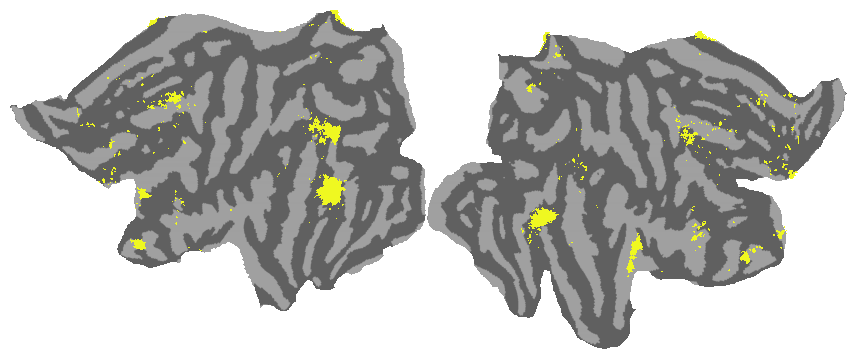

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F1=mp.uber_plot(dat=bin_unc-bin_clust_rest,dat2=bin_unc-bin_clust_rest)

Now repeat for movie-watching data.

In [8]:
myagg_mov = Aggregator(expt_id='movie', analysis_name='TEST', agg_name='movagg')  # Create an instance of the Aggregator class for the 'movie' experiment with analysis name 'TEST' and aggregator name 'newagg'
myagg_mov.load_all_sub_frames(myagg_mov.all_subjects)
topsom_mov=np.array([frame['test_scores_somato_score']-frame['null_score_somato'] for frame in myagg_mov.frames])
topsom_mov_c,_=mch.decompose_data(topsom_mov)

In [15]:
cluster_result_mov=cluster_t_test(topsom_mov_c)

stat_fun(H1): min=nan max=nan
Running initial clustering …


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tmp/ipykernel_3938869/588389024.py:3: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustL, clusters_L, p_values_L, H0_L = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 459 clusters


100%|██████████| Permuting : 1999/1999 [00:43<00:00,   45.81it/s]

stat_fun(H1): min=nan max=nan
Running initial clustering …



/tmp/ipykernel_3938869/588389024.py:4: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustR, clusters_R, p_values_R, H0_R = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=critical_t_value, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 422 clusters


100%|██████████| Permuting : 1999/1999 [00:43<00:00,   45.61it/s]


In [38]:
detected_clusters_mov=np.array(cluster_result_mov[-1])[np.array(cluster_result_mov[1])<.05,:]
detected_clusters_mov*= np.arange(1, detected_clusters_mov.shape[0]+1)[:, None]
flat_clusters_mov=np.max(detected_clusters_mov,axis=0)

In [9]:
uncorrected_t_mov,p=stats.ttest_1samp(topsom_mov_c.T,0,axis=0)

In [ ]:
bin_clust_mov=(flat_clusters_mov>0).astype(int)
bin_unc_mov=(uncorrected_t_mov>critical_t_value).astype(int)

<Figure size 1800x900 with 0 Axes>

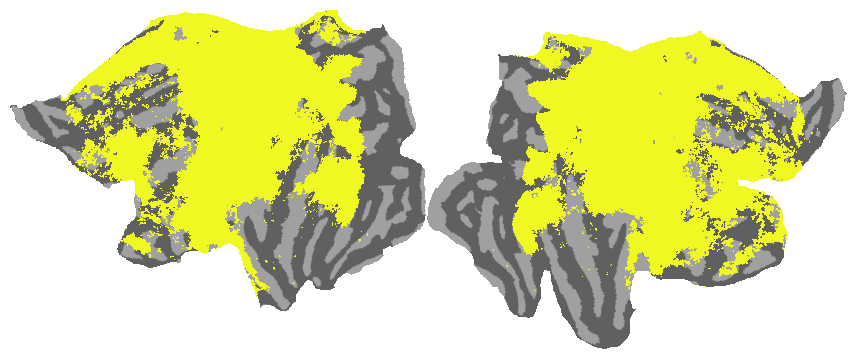

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])
F1=mp.uber_plot(dat=bin_unc_mov,dat2=bin_unc_mov)

<Figure size 1800x900 with 0 Axes>

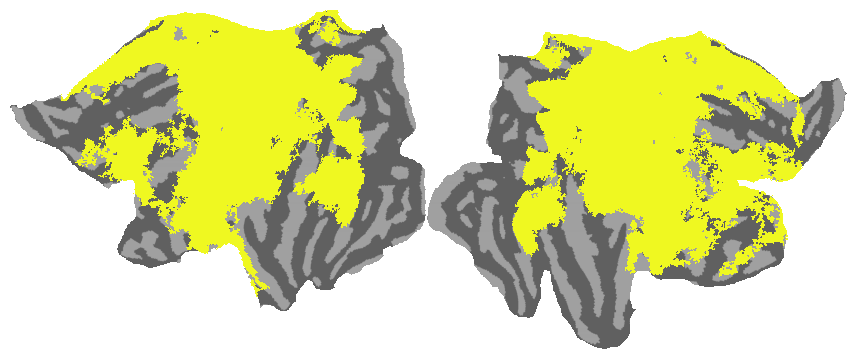

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F=mp.uber_plot(dat=bin_clust_mov,dat2=bin_clust_mov)

<Figure size 1800x900 with 0 Axes>

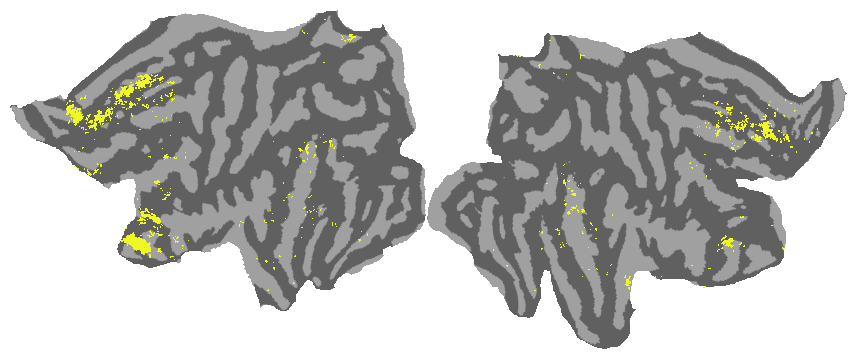

In [ ]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F1=mp.uber_plot(dat=bin_unc_mov-bin_clust_mov,dat2=bin_unc_mov-bin_clust_mov)

To avoid setting an arbitrary cluster-forming threshold, we can use Threshold Free Cluster Correction (TFCC) to determine the threshold based on the data.

In [11]:
threshold_tfce = dict(start=0, step=0.2)
data=topsom_rest_c
vertsperhem=int(data.shape[0]/2)
n_permutations=2000
t_clustL, clusters_L, p_values_L, H0_L = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)
t_clustR, clusters_R, p_values_R, H0_R = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)

data=topsom_mov_c

t_clustLmov, clusters_Lmov, p_values_Lmov, H0_Lmov = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)
t_clustRmov, clusters_Rmov, p_values_Rmov, H0_Rmov = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


stat_fun(H1): min=nan max=nan
Running initial clustering …
Using 556 thresholds from 0.00 to 111.00 for TFCE computation (h_power=2.00, e_power=0.50)


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tmp/ipykernel_2198396/249970922.py:5: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustL, clusters_L, p_values_L, H0_L = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 59292 clusters


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | Permuting : 0/1999 [00:00<?,       ?it/s]/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tank/hedger/software/anaconda3/envs/

stat_fun(H1): min=nan max=nan
Running initial clustering …
Using 512 thresholds from 0.00 to 102.20 for TFCE computation (h_power=2.00, e_power=0.50)


/tank/hedger/software/anaconda3/envs/newenv/lib/python3.10/site-packages/mne/stats/parametric.py:57: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/tmp/ipykernel_2198396/249970922.py:6: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustR, clusters_R, p_values_R, H0_R = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 59292 clusters


100%|██████████| Permuting : 1999/1999 [09:37<00:00,    3.46it/s]


stat_fun(H1): min=nan max=nan
Running initial clustering …
Using 698 thresholds from 0.00 to 139.40 for TFCE computation (h_power=2.00, e_power=0.50)


/tmp/ipykernel_2198396/249970922.py:10: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustLmov, clusters_Lmov, p_values_Lmov, H0_Lmov = permutation_cluster_1samp_test(X=data[:vertsperhem,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjL, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 59292 clusters


100%|██████████| Permuting : 1999/1999 [09:31<00:00,    3.50it/s]


stat_fun(H1): min=nan max=nan
Running initial clustering …
Using 622 thresholds from 0.00 to 124.20 for TFCE computation (h_power=2.00, e_power=0.50)


/tmp/ipykernel_2198396/249970922.py:11: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_clustRmov, clusters_Rmov, p_values_Rmov, H0_Rmov = permutation_cluster_1samp_test(X=data[vertsperhem:,:].T, n_jobs=20, threshold=threshold_tfce, adjacency=adjR, out_type='indices',seed=1234,tail=0,n_permutations=n_permutations)


Found 59292 clusters


100%|██████████| Permuting : 1999/1999 [09:22<00:00,    3.55it/s]


In [24]:
thresh_free_rest=np.logical_and(np.concatenate([p_values_L,p_values_R])<.01,np.concatenate([t_clustL,t_clustR])>0)
thresh_free_mov=np.logical_and(np.concatenate([p_values_Lmov,p_values_Rmov])<.01,np.concatenate([t_clustLmov,t_clustRmov])>0)

<Figure size 1800x900 with 0 Axes>

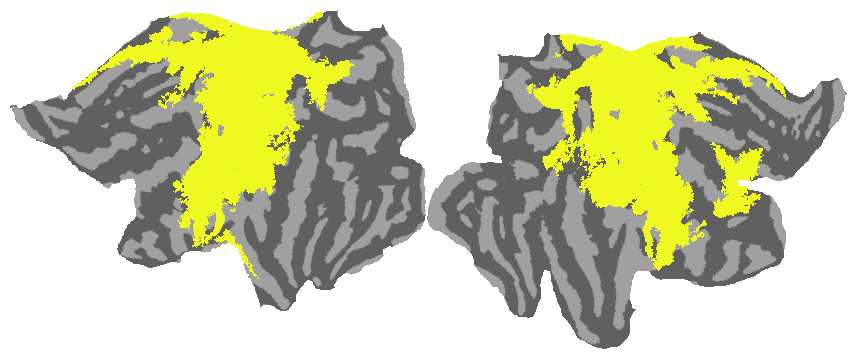

In [29]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F=mp.uber_plot(dat=thresh_free_rest,dat2=thresh_free_rest)

<Figure size 1800x900 with 0 Axes>

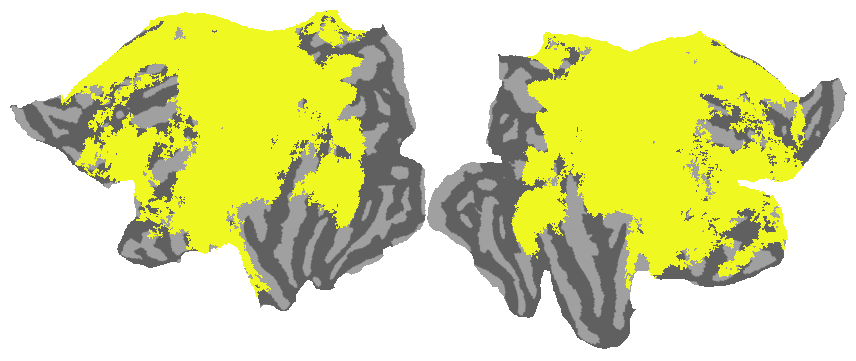

In [30]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F=mp.uber_plot(dat=thresh_free_mov,dat2=thresh_free_mov)

<Figure size 1800x900 with 0 Axes>

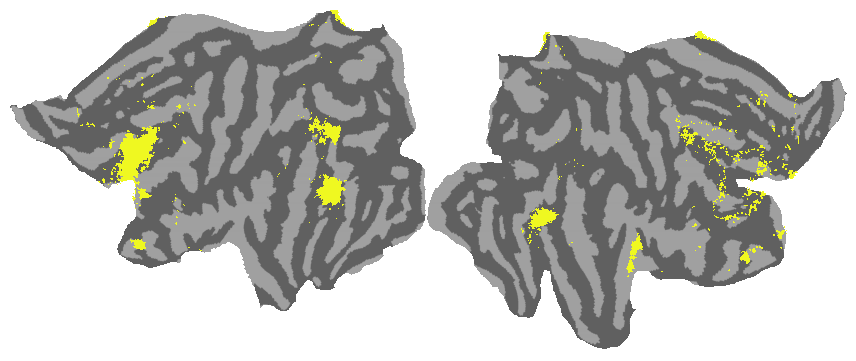

In [31]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F=mp.uber_plot(dat=bin_unc-thresh_free_rest,dat2=bin_unc-thresh_free_rest)

<Figure size 1800x900 with 0 Axes>

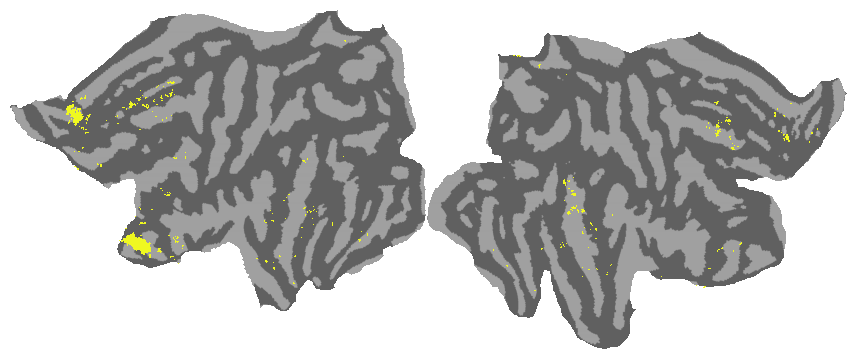

In [32]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['bin_mask_mov'])

F=mp.uber_plot(dat=bin_unc_mov-thresh_free_mov,dat2=bin_unc_mov-thresh_free_mov)